<a href="https://colab.research.google.com/github/mahdiAkhi/HDNA/blob/main/H_DNA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implementation of **H-DNA** algorithm
HDNA is an algorithm which can help you to detect changes and difference in tree structures like HTML. Here you can see the implementation and use case.

This algorithm is available on google colab from [here](https://colab.research.google.com/drive/1nMDlqEAwVF3LXfjEJyvEDB-tVxi0Ea28?usp=sharing).

## Install required libs

In [15]:
# install required libs
!pip install anytree
!pip install beautifulsoup4
!pip install request

ERROR: Could not find a version that satisfies the requirement request (from versions: none)
ERROR: No matching distribution found for request


In [16]:
# import required libs: BeautifulSoup4 and requests
from bs4 import BeautifulSoup
from bs4.element import NavigableString
import requests
from anytree import AnyNode, RenderTree, LevelOrderIter
from anytree.exporter import DotExporter
from IPython.display import Image

## 1. Fetch web page from url and create BS object

In [17]:
# Get web page
url = 'https://google.com'
site = requests.get(url).text

# pass the webpage to the BS4 with lxml parser
soup = BeautifulSoup(site,'html5lib')
# print(soup.prettify())

## 2. Preprocessing


1.   remove useless tags: meta, link, style, script

2.  extract HTML structure:
  *   remove tags attribute like class, id, href, src, etc.
  *   strip content

In [ ]:
# array of tags that have no impact on the algorithm
useless_tags=['script','meta','link','style','br','input']

def removeUselessTags(soup):
  for s in soup(useless_tags):
    s.decompose()
  return soup


def removeTagsAttr(soup):
  tag_list = soup.findAll(lambda tag: len(tag.attrs) > 0)
  for t in tag_list:
    t.attrs={}
  return soup

def removeText(soup):
  tag_list = soup.findAll(lambda tag: len(tag.text) > 0)
  return soup

def strip_content(tag):
    # strip content from all children
    children = [strip_content(child) for child in tag.children if not isinstance(child, NavigableString)]
    # remove everything from the tag
    tag.clear()
    for child in children:
        # Add back stripped children
        tag.append(child)
    return tag

removeUselessTags(soup)
removeTagsAttr(soup)
strip_content(soup)

print(soup.prettify())

## 3.Generate Dom tree

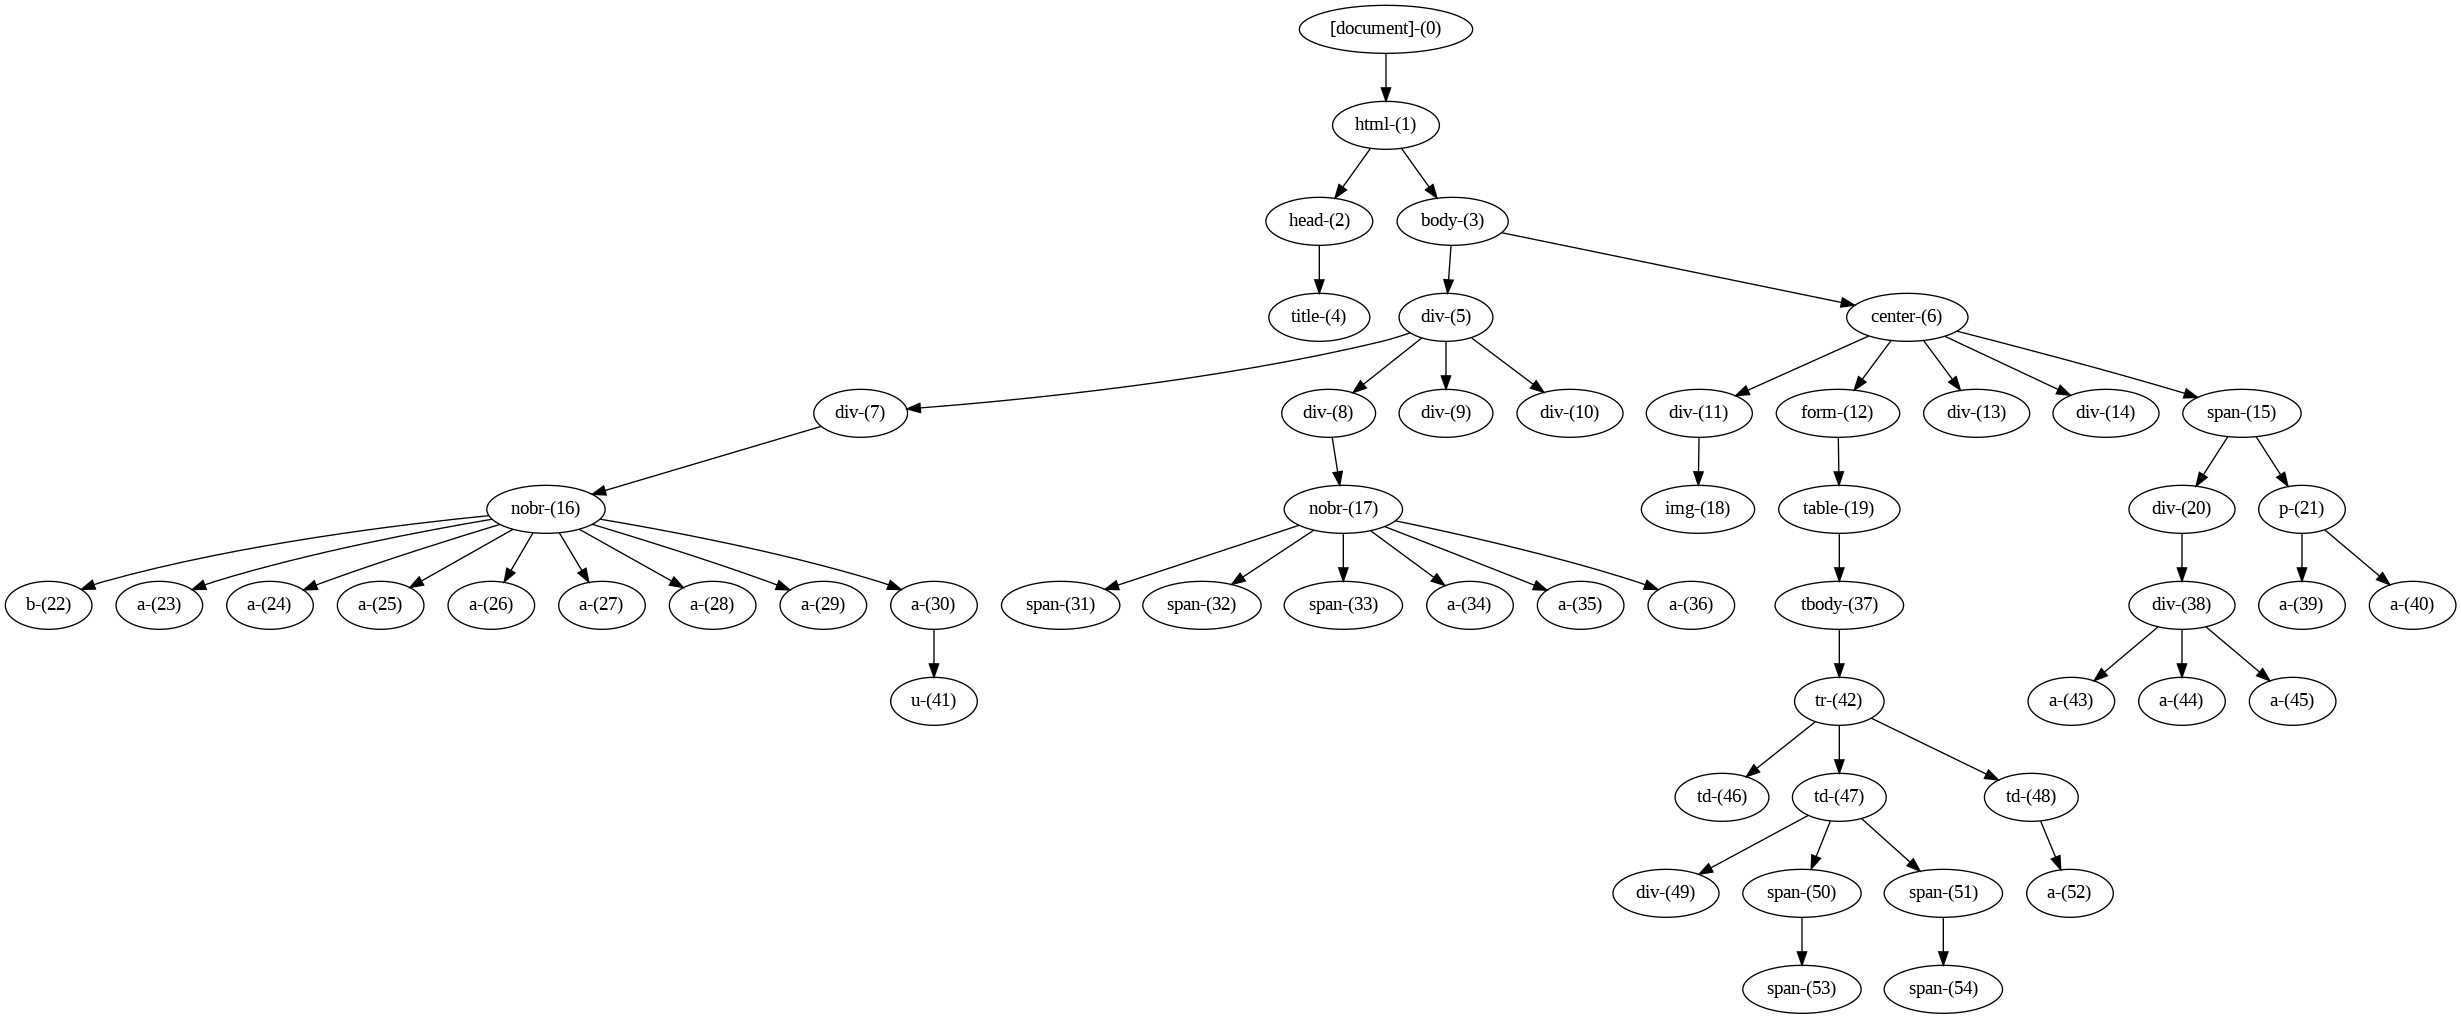

In [19]:
# Generate Dom tree
nodes=[AnyNode(id=soup.html.parent.name,name=soup.html.parent.name,weight=0)]

def traverse(soup,parent):
  key=name = "{tag_name}".format(tag_name=soup.name)
  node = AnyNode(id=key, parent=parent)
  nodes.append(node)
  for child in soup.children:
    if child.name is not None:
      traverse(child,node)

traverse(soup.html, nodes[0])

# node number
i=0
for node in LevelOrderIter(nodes[0], maxlevel=nodes[0].height+1):
  index = nodes.index(node)
  nodes[index].n=i
  i=i+1

# Save tree view picture
DotExporter(nodes[0], graph="digraph",nodenamefunc=lambda n: n.id+'-('+str(n.n)+')').to_picture("graph.png")

# Save tree as dot file
DotExporter(nodes[0], graph="digraph",nodenamefunc=lambda n: n.id).to_dotfile("graph.txt")

# Show picture
Image('graph.png')

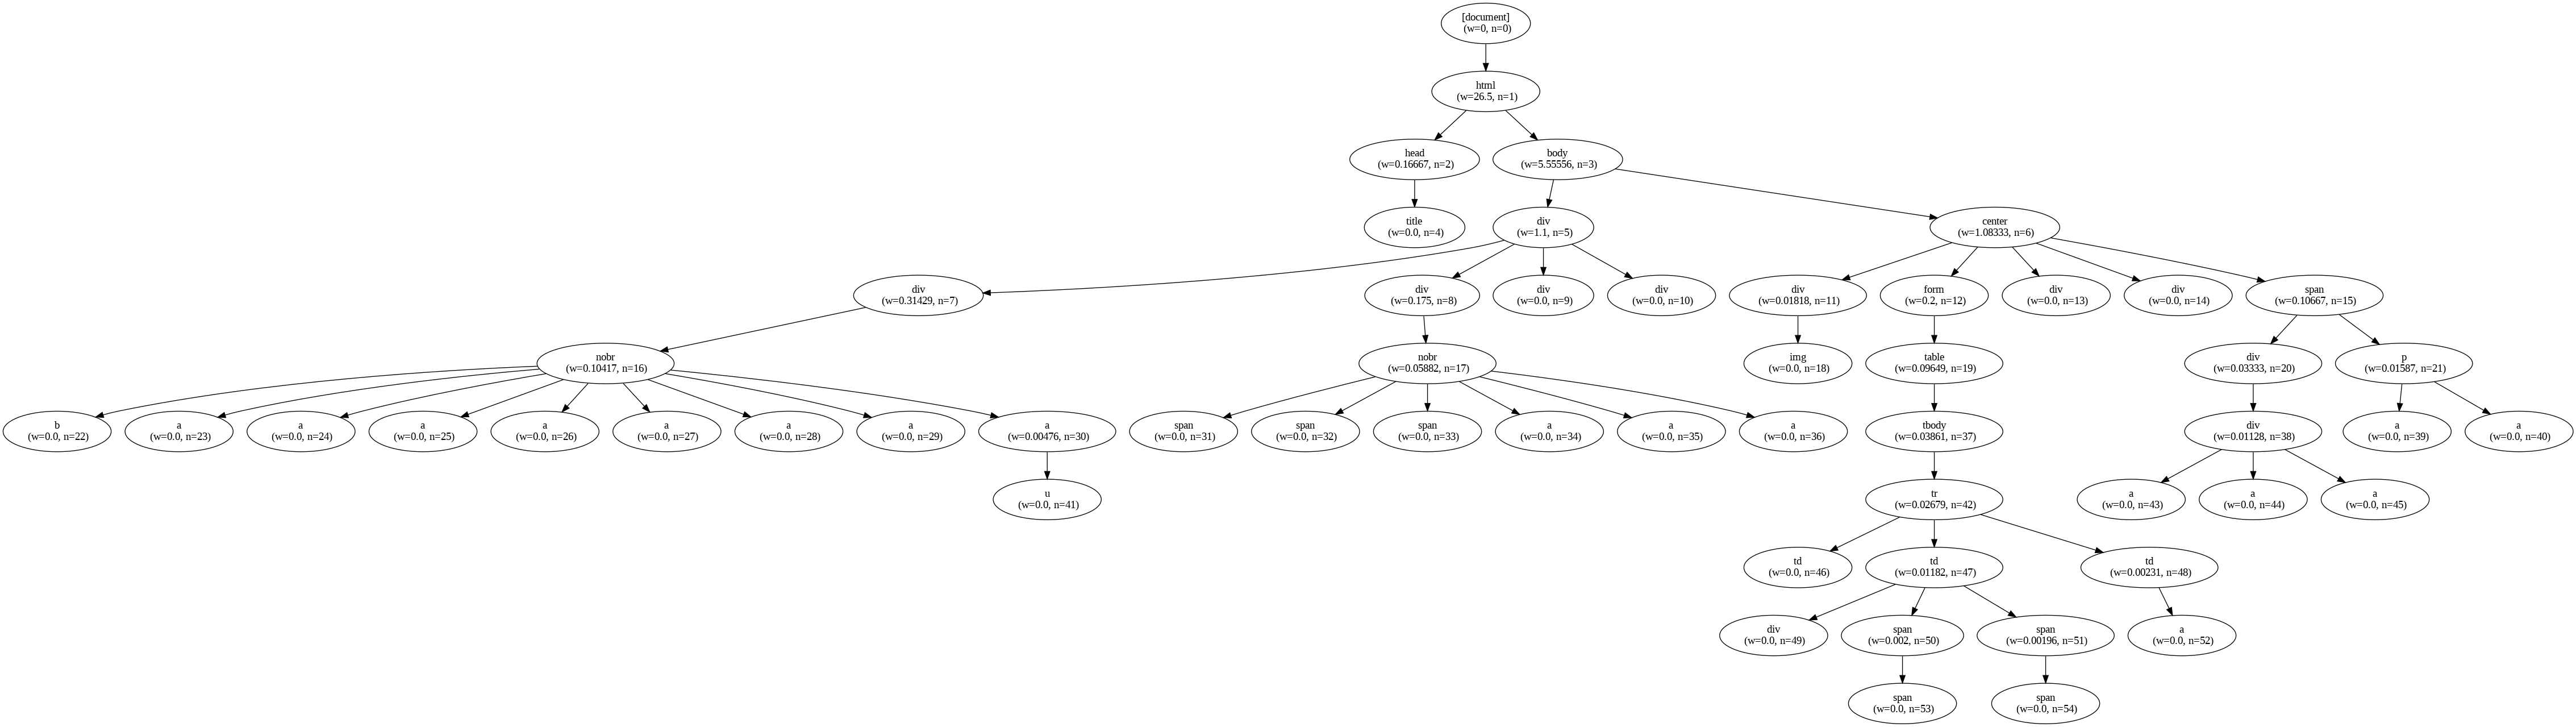

In [20]:
#Weighting
def weighting(node):
  node.a=len(node.descendants) #descendants: get number of all chlidren
  node.d=node.depth
  node.weight= round(node.a/(node.n*(node.d+1)),5) # w=A/D*N
  for child in node.children:
    if child is not None:
      weighting(child)

weighting(nodes[1])
# nodes
DotExporter(nodes[0], graph="digraph",nodenamefunc=lambda n: n.id+'\n (w='+str(n.weight)+', n='+str(n.n)+')').to_picture("graph_weighted.png")
# Show picture
Image('graph_weighted.png')

## Calculate the difference

In [ ]:
# Calculate differences
# This function doesn't work properly it will update
def calculateDiff(old, new):

  oldLevelOrder=LevelOrderIter(old[0], maxlevel=old[0].height+1)
  newLevelOrder=LevelOrderIter(new[0], maxlevel=new[0].height+1)
  min= min(len(oldLevelOrder),len(newLevelOrder))
  diff=list()

  for i in range(min):
    if oldLevelOrder[i].weight!=newLevelOrder[i].weight | oldLevelOrder[i].name!=newLevelOrder[i].name:
      diff.append(oldLevelOrder[i])
  return diff
